In [17]:
!pip3 install keras
!pip3 install matplotlib
!pip3 install numpy

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from collections import deque
import numpy as np

import time

REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMORY_SIZE = 1_000
MODEL_NAME = "256x2"


# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)


class DQNAgent:
    def __init__(self):

        # main model  # gets trained every step
        self.model = self.create_model()

        # Target model this is what we .predict against every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.tensorboard = ModifiedTensorBoard(log_dir=f"logs/{MODEL_NAME}-{int(time.time())}")
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(2, 2))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, (3, 3)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(2, 2))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(64))

        model.add(Dense(env.ACTION_SPACE_SIZE, activiation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def get_qs(self, state, step):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]
    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

ModuleNotFoundError: No module named 'tensorflow'

reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 1
reward: 1
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 1
reward: 1
reward: 1
reward: 1
reward: 1
reward: 1
reward: 1
reward: 1
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0
reward: 1
reward: 1
reward: 0
reward: 0
reward: 0
reward: 0
reward: 0


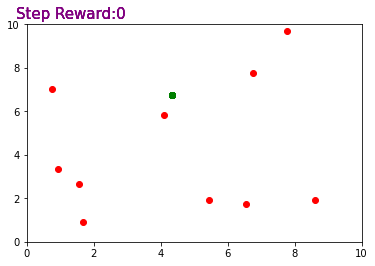

In [47]:
import numpy as np
class CellEnv:
    grid_SIZE = 10.0
    Nb_robot = 10
    RETURN_IMAGES = False
    IMPROVE_REWARD = 1
    GOAL_REWARD = 30
    velocity = 0.1
    # ENEMY_PENALTY = 300 
    # FOOD_REWARD = 25
    # OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)  # 4
    #ACTION_SPACE_SIZE = 9
    
    # the dict! (colors)
    d = {1: (255, 175, 0),
         2: (0, 255, 0),
         3: (0, 0, 255)}
    
    def reset(self):
        self.reach_goal_flag = np.zeros((1, self.Nb_robot), dtype=bool)
        self.reach_goal_count = 0
        self.goal = goal(self.grid_SIZE)
        self.robots = []
        for i in range(self.Nb_robot):
            self.robots.append(robot(self.grid_SIZE,self.velocity))
            error = [self.goal.x-self.robots[i].x, self.goal.y-self.robots[i].y]
            while  np.linalg.norm(error, ord=2) < 0.1:
                self.robots[i] = robot(self.grid_SIZE,self.velocity)
                error = [self.goal.x-self.robots[i].x, self.goal.y-self.robots[i].y]
        self.episode_step = 0
        # if self.RETURN_IMAGES:
        #     #observation = np.array(self.get_image())
        # else:
        observation = []
        error = []
        self.target_state = [self.goal.x,self.goal.y,np.array([0.0])]
        for robot_i in self.robots:
            theta_reference_i = np.arctan2(self.goal.y-robot_i.y, self.goal.x-robot_i.x)
            error_i = [self.goal.x-robot_i.x, self.goal.y-robot_i.y, theta_reference_i - robot_i.theta]
            observation_i = [robot_i.x, robot_i.y, robot_i.theta]
            observation.append(observation_i) 
            error.append(error_i)
        observation.append(self.target_state)
        observation = np.concatenate(observation,axis=1)
        observation = observation.reshape(1,3,-1)
        error = np.concatenate(error,axis=1)
        error = error.reshape(1,3,-1)
        # print(type(observation))
        # print(observation.shape)
        self.last_observation = observation
        self.last_error = error
        return observation,self.goal
    
    def step(self, action):
        self.reach_goal_flag = np.zeros((1, self.Nb_robot), dtype=bool)
        self.episode_step += 1
        reward = 0
        # if self.RETURN_IMAGES:
        #     # new_observation = np.array(self.get_image())
        # else:
        for robot_i in self.robots:
            robot_i.follow_action(action)
        theta_reference = []
        error = []
        new_observation = []
        for robot_i in self.robots:
            theta_reference_i = np.arctan2(self.goal.y-robot_i.y, self.goal.x-robot_i.x)
            error_i = [self.goal.x-robot_i.x, self.goal.y-robot_i.y, theta_reference_i - robot_i.theta]
            observation_i = [robot_i.x, robot_i.y, robot_i.theta]
            theta_reference.append(theta_reference_i)
            new_observation.append(observation_i)
            error.append(error_i)
        new_observation.append(self.target_state)
        new_observation = np.concatenate(new_observation,axis=1)
        new_observation = new_observation.reshape(1,3,-1)
        error = np.concatenate(error,axis=1)
        error = error.reshape(1,3,-1)

        done = False
        
        i = 0
        for robot_i in self.robots:
            if abs(robot_i.x - self.goal.x)<3e-1 and abs(robot_i.y - self.goal.y)<3e-1:
                self.reach_goal_flag[0,i] = True
            i = i+1
        if sum(sum(np.abs(error[0,0:2,:])-np.abs(self.last_error[0,0:2,:]))) > 0.4:  
            reward += self.IMPROVE_REWARD
        if np.count_nonzero(self.reach_goal_flag)>self.reach_goal_count:
            self.reach_goal_count=np.count_nonzero(self.reach_goal_flag)
            reward += self.GOAL_REWARD
        if  self.episode_step >= 200:  #reward == self.FOOD_REWARD or reward == -self.ENEMY_PENALTY or
            done = True
        self.last_observation = new_observation[:][:][:]
        self.last_error = error[:][:][:]
        return new_observation, reward, done

    # def render(self):
        # img = self.get_image()
        # img = img.resize((300, 300))  # resizing so we can see our robot in all its glory.
        # cv2.imshow("image", np.array(img))  # show it!
        # cv2.waitKey(1)

class goal:
    def __init__(self, size):
        self.size = size
        self.x = np.random.uniform(0.1*size, 0.9*size, 1) # dont be too close to the boundary
        self.y = np.random.uniform(0.1*size, 0.9*size, 1) ##np.random.random(0.1*size, 0.9*size)

class robot:
    def __init__(self, size,velocity):
        self.size = size
        self.velocity = velocity
        self.x = np.random.uniform(0.05*size, 0.95*size, 1) 
        self.y = np.random.uniform(0.05*size, 0.95*size, 1) 
        self.theta = np.random.uniform(-np.pi,np.pi,1)
        self.mu, self.sigma =  np.pi/4, np.pi/180*5 # mean and standard deviation

    def __str__(self):
        return f"mi-robot ({self.x}, {self.y},{self.theta})"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y, self.theta-other.theta)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def follow_action(self, choice):
        if choice == 1:
            delta_theta = np.random.normal(self.mu, self.sigma)
            self.theta = self.theta + delta_theta
            if self.theta > np.pi:
                self.theta -= 2*np.pi
            elif self.theta < -np.pi:
                self.theta += 2*np.pi
        elif choice == 0:
            self.theta = self.theta
        self.move(xx=self.velocity*np.cos(self.theta), yy=self.velocity*np.sin(self.theta))

    def move(self, xx=False, yy=False):

        # If no value for x, move randomly
        if not xx:
            print("no x")# self.x += np.random.randint(-1, 2)
        else:
            self.x += xx

        # If no value for y, move randomly
        if not yy:
            print("no y")# self.y += np.random.randint(-1, 2)
        else:
            self.y += yy

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = np.array([0.])
            #print("xlow")
        elif self.x > self.size:
            self.x = np.array([self.size])
            #print("xhigh")
        if self.y < 0:
            self.y = np.array([0.])
            #print("ylow")
        elif self.y > self.size:
            self.y = np.array([self.size])
            #print("yhigh")

class goal:
    def __init__(self, size):
        self.size = size
        self.x = np.random.uniform(0.1*size, 0.9*size, 1) # dont be too close to the boundary
        self.y = np.random.uniform(0.1*size, 0.9*size, 1) ##np.random.random(0.1*size, 0.9*size)
        
env = CellEnv()

# # For stats
# ep_rewards = [-200]
# For more repetitive results
# random.seed(1)
# tf.set_random_seed(1)
np.random.seed(1)

# import os
# # Create models folder
# if not os.path.isdir('models'):
#     os.makedirs('models')
episode_reward = 0
step = 1
# Reset environment and get initial state
current_state,goal = env.reset()
episode_reward = 0
epsilon = 1
#After restarting the episode and state, we're ready to iterate over the steps per episode:
# Reset flag and start iterating until episode ends
all_state_buffer = [current_state[:][:][:]];
all_reward_buffer = [];
done = False
while not done:
    # This part stays mostly the same, the change is to query a model for Q values
    if np.random.random() > epsilon:
        # Get action from Q table
        #action = np.argmax(agent.get_qs(current_state))
        action = np.random.randint(0, 2)
    else:
        # Get random action
        action = np.random.randint(0, 2)
    new_state, reward, done = env.step(action)
    episode_reward += reward
    print("reward:",reward)
        # if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
        #     env.render()
        # Every step we update replay memory and train main network
        #agent.update_replay_memory((current_state, action, reward, new_state, done))
        #agent.train(done, step)
    current_state = new_state[:][:][:]
    step += 1
    all_state_buffer.append(current_state[:][:][:]);
    all_reward_buffer.append(reward)
all_reward_buffer = np.array(all_reward_buffer)
print(all_reward_buffer)
print(all_reward_buffer.shape)
# all_reward_buffer = np.concatenate(all_reward_buffer,axis=0)
# print(all_reward_buffer)

print("episode reward:",episode_reward)


# print(np.array(all_state_buffer[1])[:,1])
# print(goal.x-all_state_buffer[1][1,:])
# print(goal.y-all_state_buffer[1][2,:])
# print(all_state_buffer[10][1,:])
# for i in range(len(all_state_buffer)):
#     print(all_state_buffer[i][2,:])
#     print(all_state_buffer[i][2,:]<0)
import matplotlib.pyplot as plt
import matplotlib.animation as animation

grid_SIZE = 10
Nb_agent = 10
fig, ax = plt.subplots()
ax.plot([goal.x],[goal.y],'go')
ax.axis([0,grid_SIZE,0,grid_SIZE])
l, = ax.plot([],[],'ro')

def animate(i):
    if i > 0:
        del fig.texts[0]
    ax.plot([goal.x],[goal.y],'go')
    l.set_data(all_state_buffer[i][0,0,:], all_state_buffer[i][0,1,:])
    fig.text(0.1, 0.9, 'Step Reward:'+str(all_reward_buffer[i-1]), size=15, color='purple')
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100 ) #len(all_state_buffer)

from IPython.display import HTML
HTML(ani.to_jshtml())
f = r"cell_movement_animation.gif" 
writergif = animation.PillowWriter(fps=5) 
ani.save(f, writer=writergif)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
import random
print(random.randrange(2))

In [ ]:
import numpy as np
arr_2d = np.zeros((1, 10), dtype=bool)
arr_2d[0,5]=True
print(arr_2d)
np.count_nonzero(arr_2d)

[[False False False False False  True False False False False]]


1